In [ ]:
### 

## Plastic pollution poses a significant threat to marine ecosystems worldwide. This project aims to address this challenge by harnessing the power of computer vision and artificial intelligence. The proposed model will be trained on a custom dataset obtained from The Global Oceanographic Data Center, featuring images and videos captured in diverse oceanic environments. The YOLOv8 architecture will serve as the foundation of the plastic detec- tion model due to its optimal balance between computational efficiency and accuracy. The architecture’s speed and accuracy make it suitable for detecting plastic objects in dynamic oceanic scenes. Additionally, the model will be enriched with the ByteTrack algorithm for advanced object tracking and counting capabilities.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/nadiera/Downloads/DeepPlastic-v1/DeepPlastic/Dataset/DeepTrash-Yolov8


In [2]:
import torch
import numpy as np 
import cv2
from time import perf_counter
from ultralytics import YOLO
import supervision as sv
from bytetracker.byte_tracker import BYTETracker
from strongsort.strong_sort import StrongSORT


In [5]:
%cd ByteTrack

/home/nadiera/Downloads/DeepPlastic-v1/DeepPlastic/Dataset/DeepTrash-Yolov8/ByteTrack


In [7]:


from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import random
from PIL import Image as PILImage
import cv2
import numpy as np
import yaml
import torch
import time
from collections import deque
     


In [8]:
from yolox.tracker.byte_tracker import BYTETracker, STrack


In [9]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [10]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator


In [8]:
# from typing import List
# import numpy as np

# # Update the BoxAnnotator class
# class BoxAnnotator:
#     def __init__(self, color, thickness=1, text_thickness=1, text_scale=1, font=cv2.FONT_HERSHEY_SIMPLEX, font_color=(0, 0, 255)):
#         self.color = color
#         self.thickness = thickness
#         self.text_thickness = text_thickness
#         self.text_scale = text_scale
#         self.font = font
#         self.font_color = font_color

#     def annotate(self, frame, detections, labels):
#         for detection, label in zip(detections, labels):
#             tlbr = detection[:4].astype(int)
#             confidence = detection[4]
#             class_id = detection[5]

#             # Draw bounding box
#             frame = cv2.rectangle(frame, (tlbr[0], tlbr[1]), (tlbr[2], tlbr[3]), self.color.get(class_id), self.thickness)

#             # Add label text
#             label_text = f"{label} {confidence:.2f}"
#             text_size, _ = cv2.getTextSize(label_text, self.font, self.text_scale, self.text_thickness)
#             text_origin = (tlbr[0], tlbr[1] - text_size[1] - 5)
#             frame = cv2.putText(frame, label_text, text_origin, self.font, self.text_scale, self.font_color, self.text_thickness, cv2.LINE_AA)

#         return frame

# # Update the color palette class to add custom colors for underwater classes
# class ColorPalette:
#     def __init__(self):
#         self.colors = [
#             (255, 0, 0),    # Red
#             (0, 255, 0),    # Green
#             (0, 0, 255),    # Blue
#             # Add more custom colors for underwater classes
#             (0, 255, 255),  # Cyan
#             (255, 0, 255),  # Magenta
#             (255, 255, 0),  # Yellow
#         ]

#     def get(self, class_id):
#         return self.colors[class_id % len(self.colors)]


In [11]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [12]:
MODEL = "/home/nadiera/Downloads/DeepPlastic-v1/DeepPlastic/Dataset/DeepTrash-Yolov8/runs/detect/train/weights/best.pt"



In [14]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


In [16]:
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [0]

In [23]:
SOURCE_VIDEO_PATH = f"/home/nadiera/Downloads/A Diver Filmed Shocking Footage Of Plastic Waste Off The Coast Of Bali.mp4"


0: 384x640 5 plastics, 9.7ms
Speed: 11.9ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


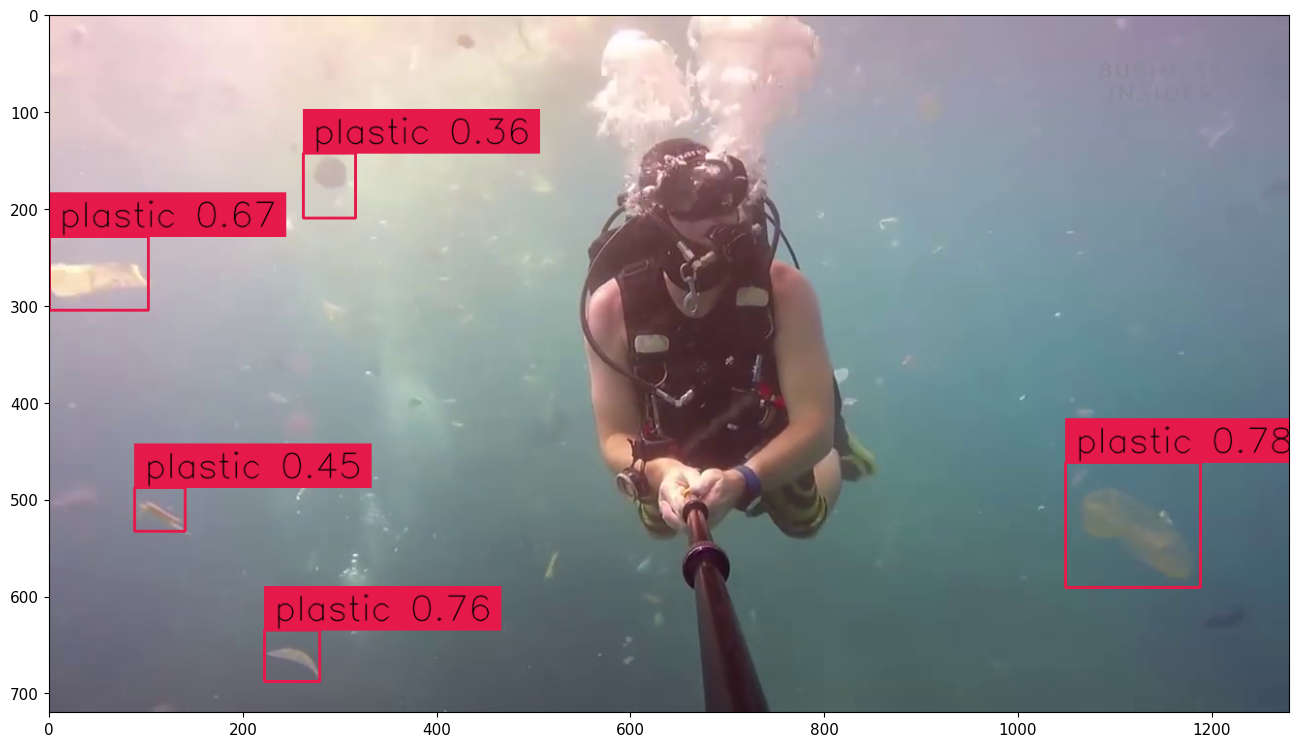


0: 384x640 6 plastics, 8.9ms
Speed: 1.4ms preprocess, 8.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


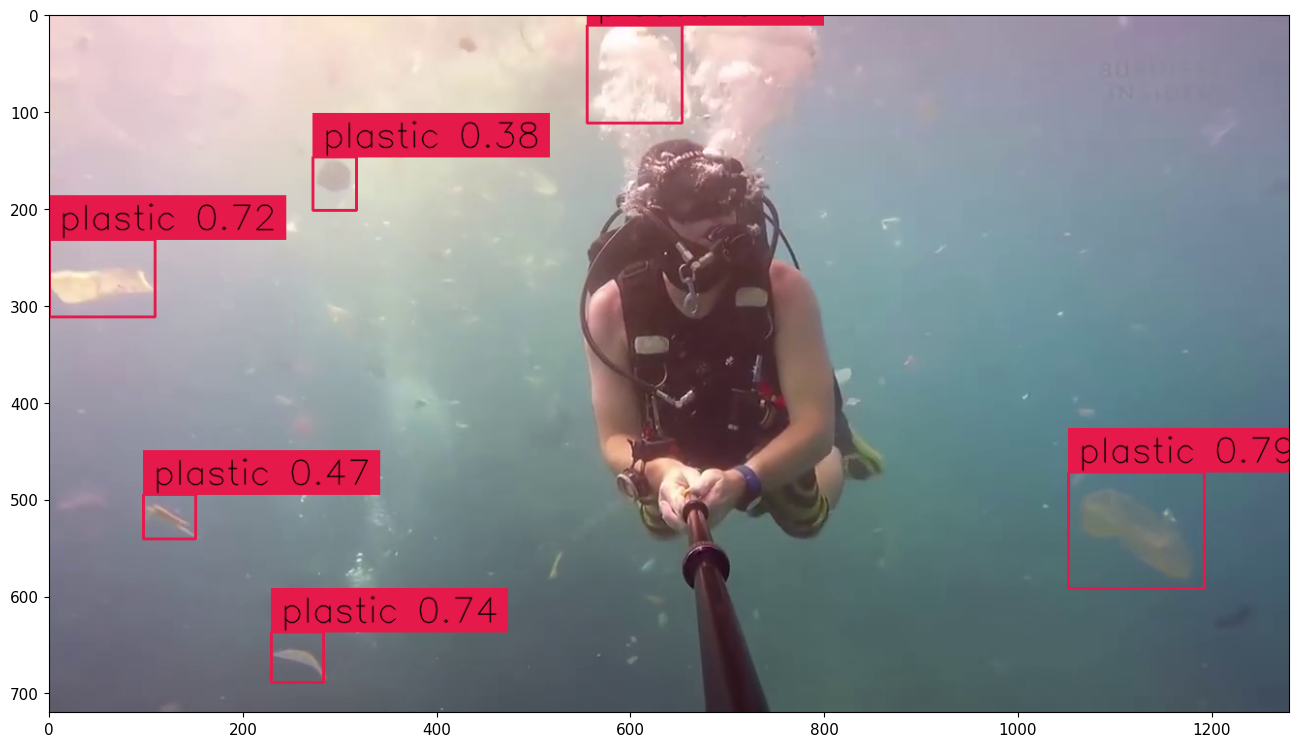


0: 384x640 6 plastics, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


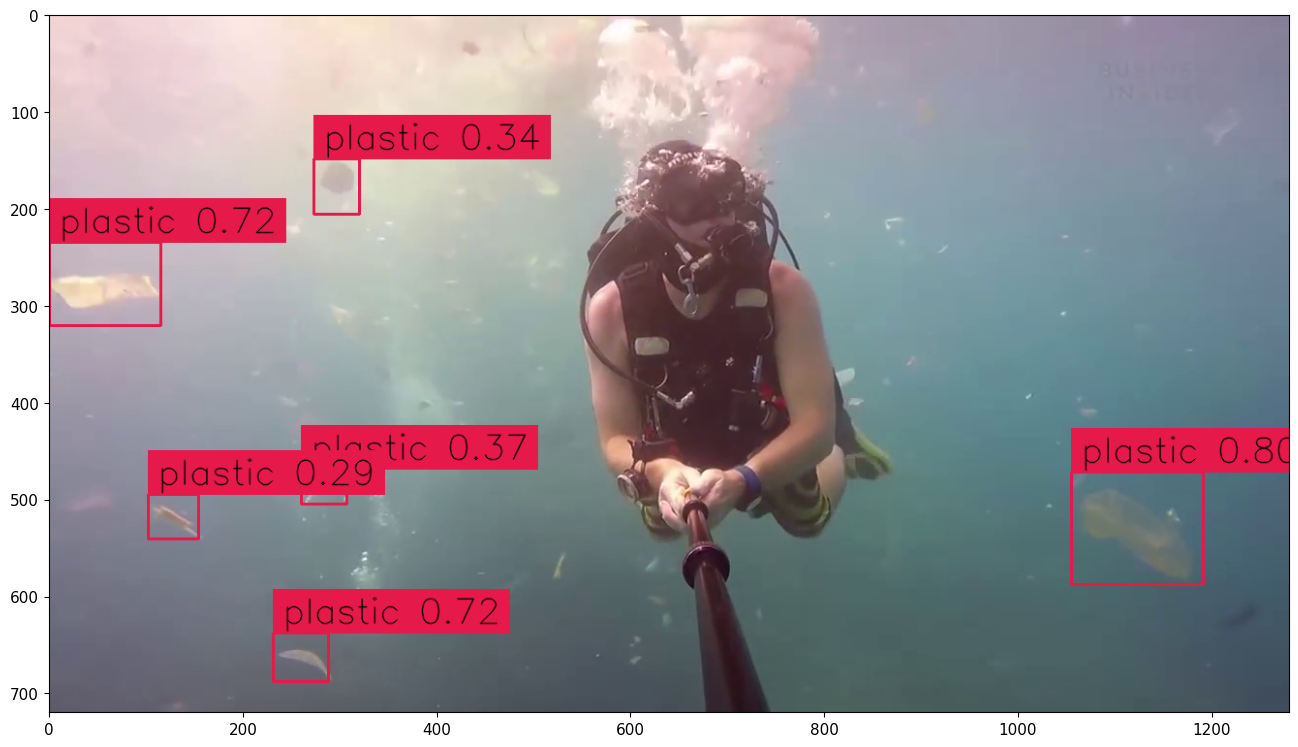


0: 384x640 4 plastics, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


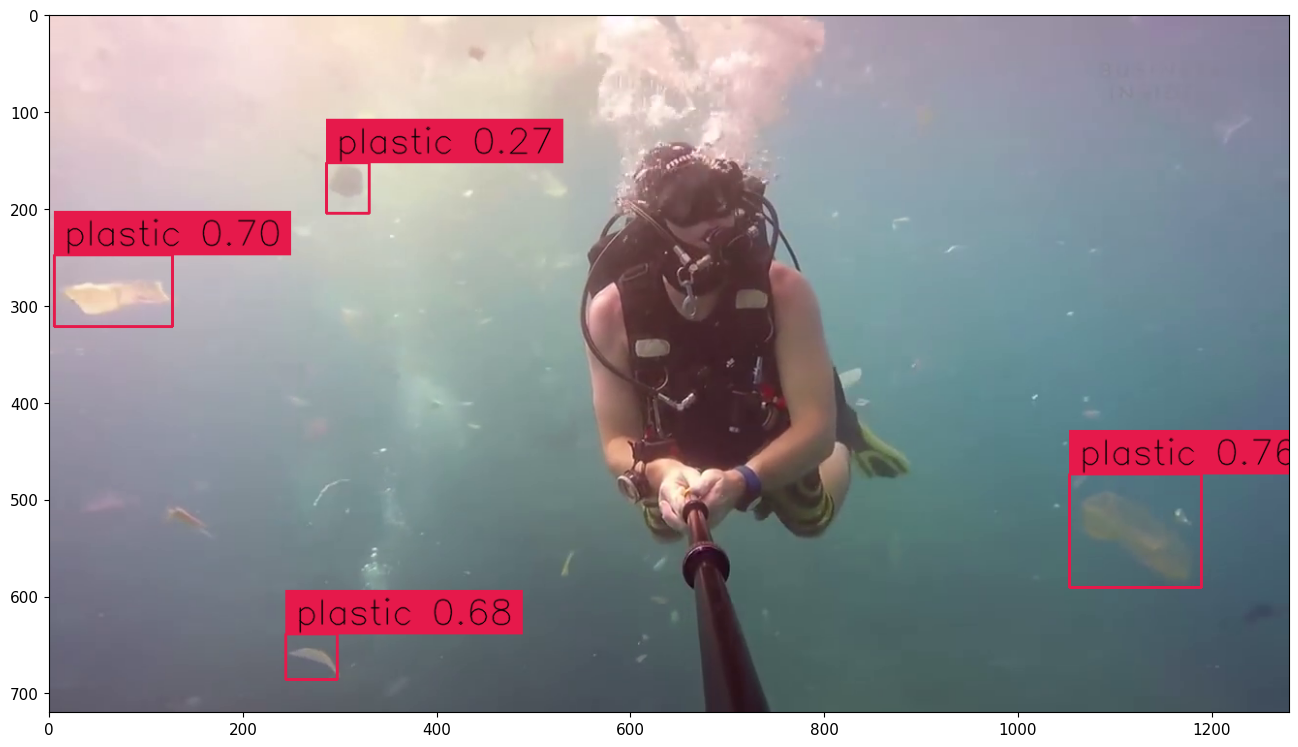


0: 384x640 4 plastics, 8.7ms
Speed: 1.1ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


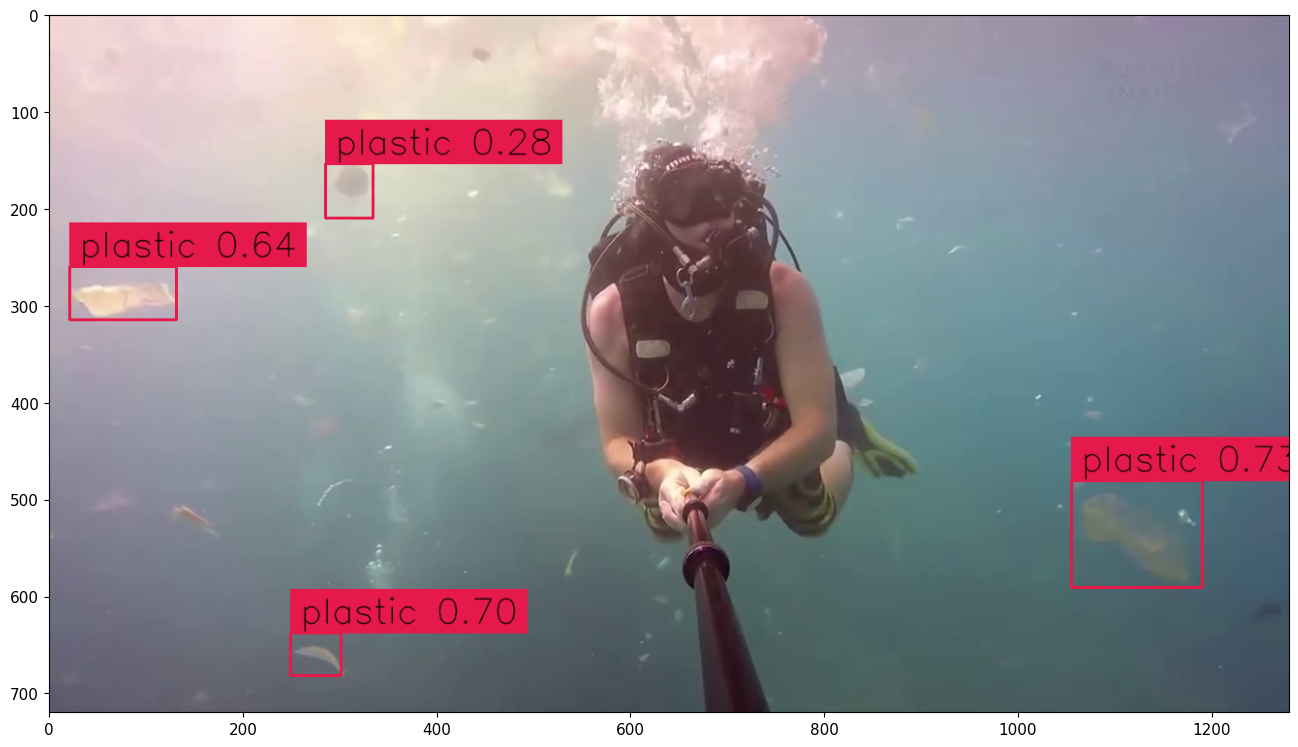


0: 384x640 3 plastics, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


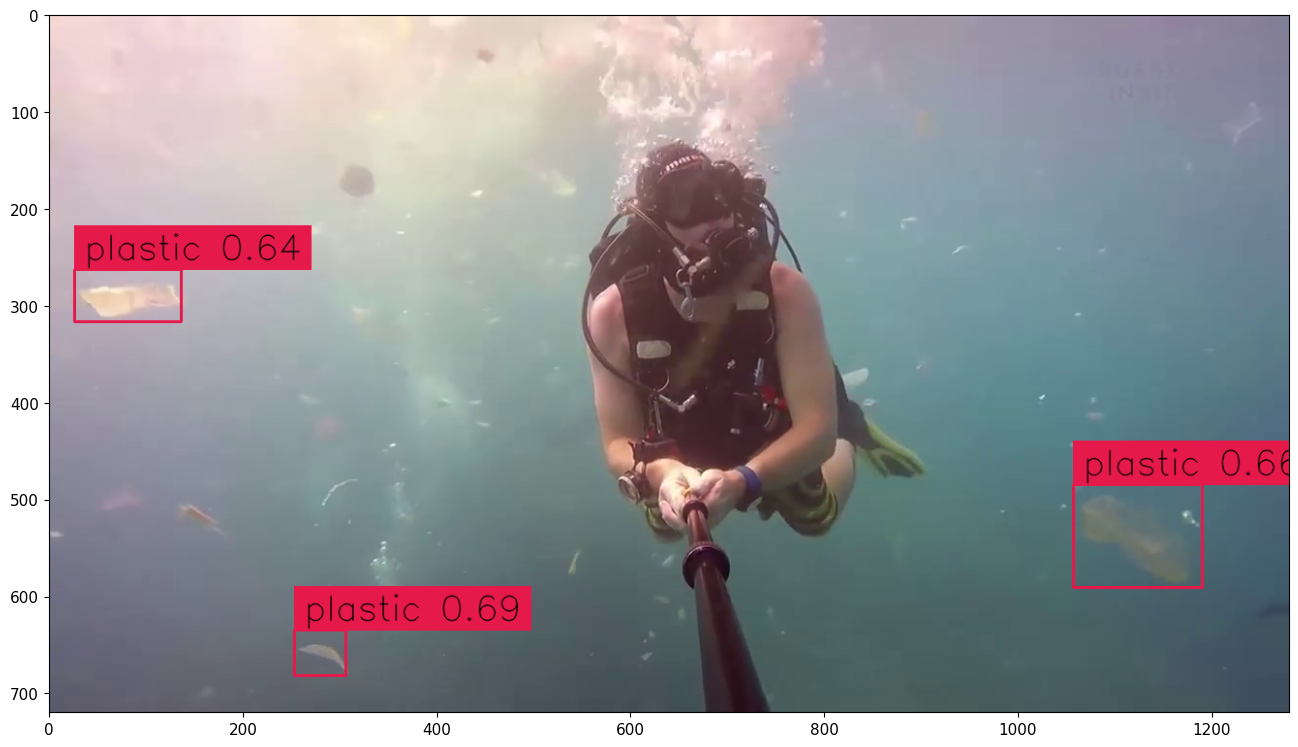


0: 384x640 4 plastics, 8.6ms
Speed: 1.0ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


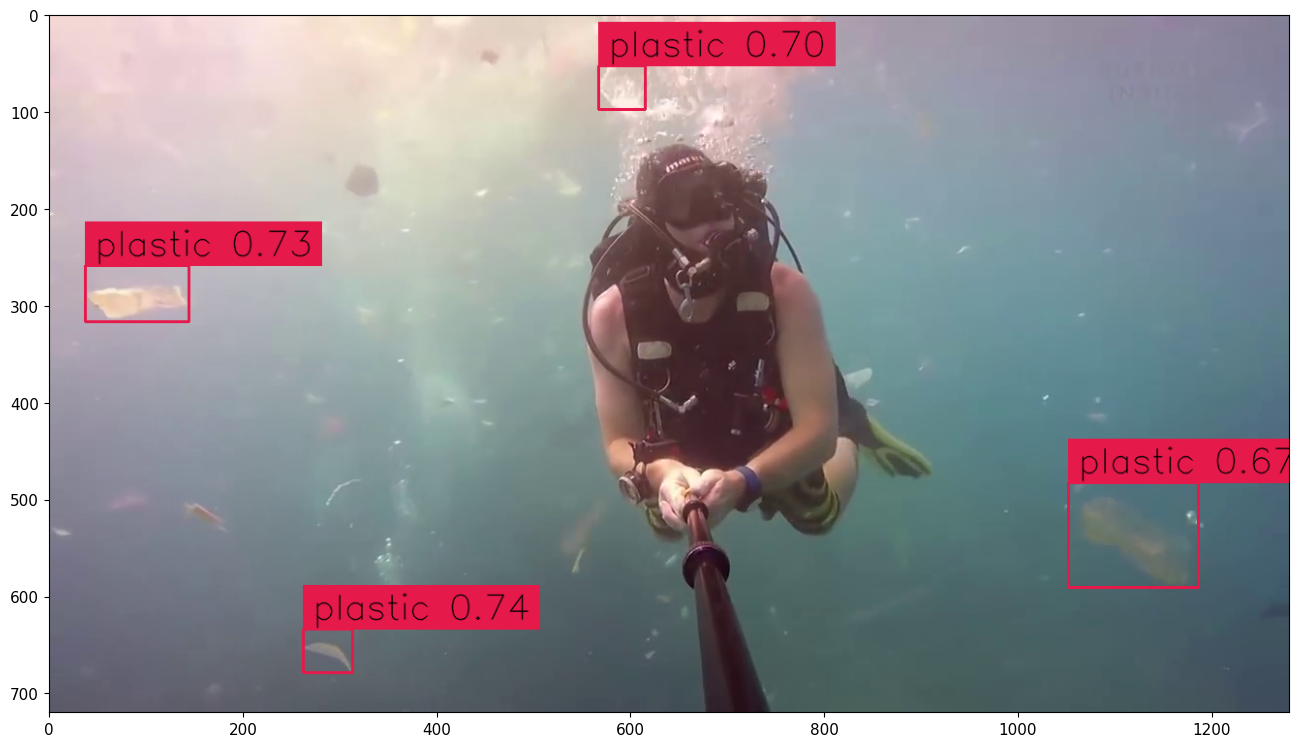


0: 384x640 5 plastics, 9.9ms
Speed: 1.1ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


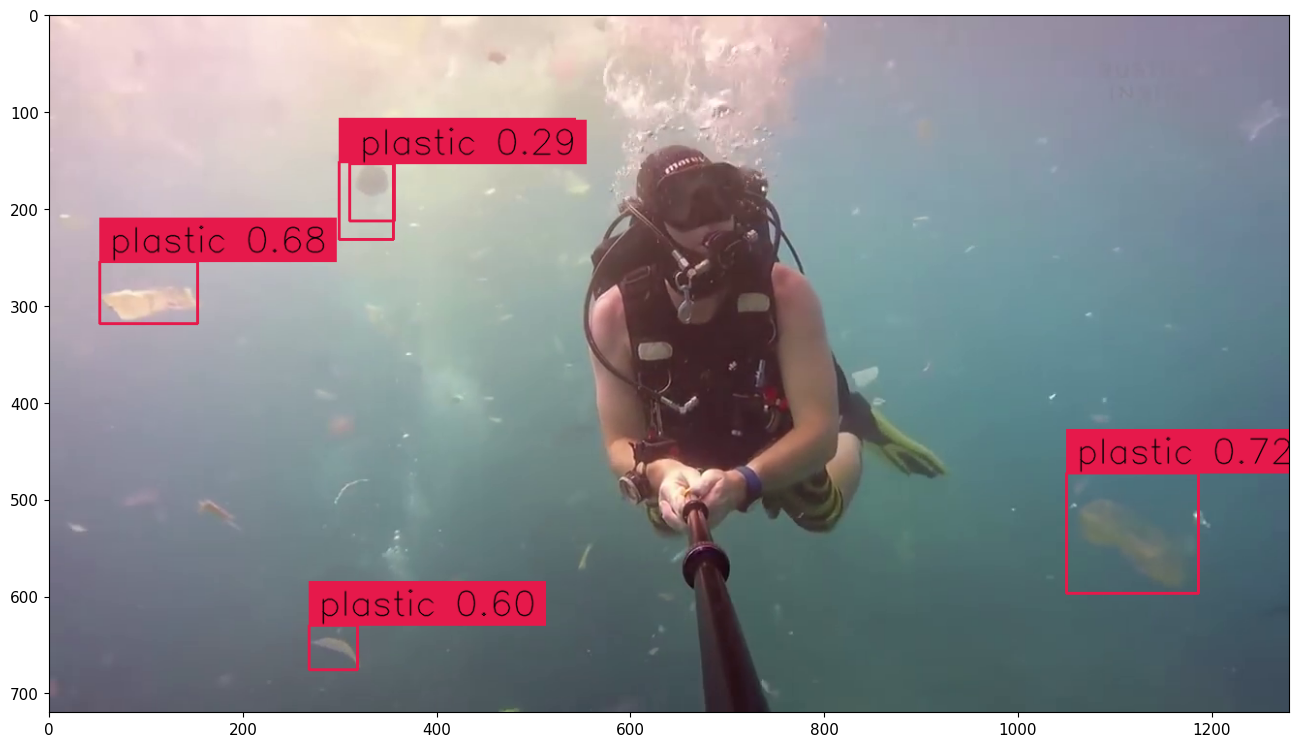


0: 384x640 5 plastics, 9.5ms
Speed: 1.1ms preprocess, 9.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


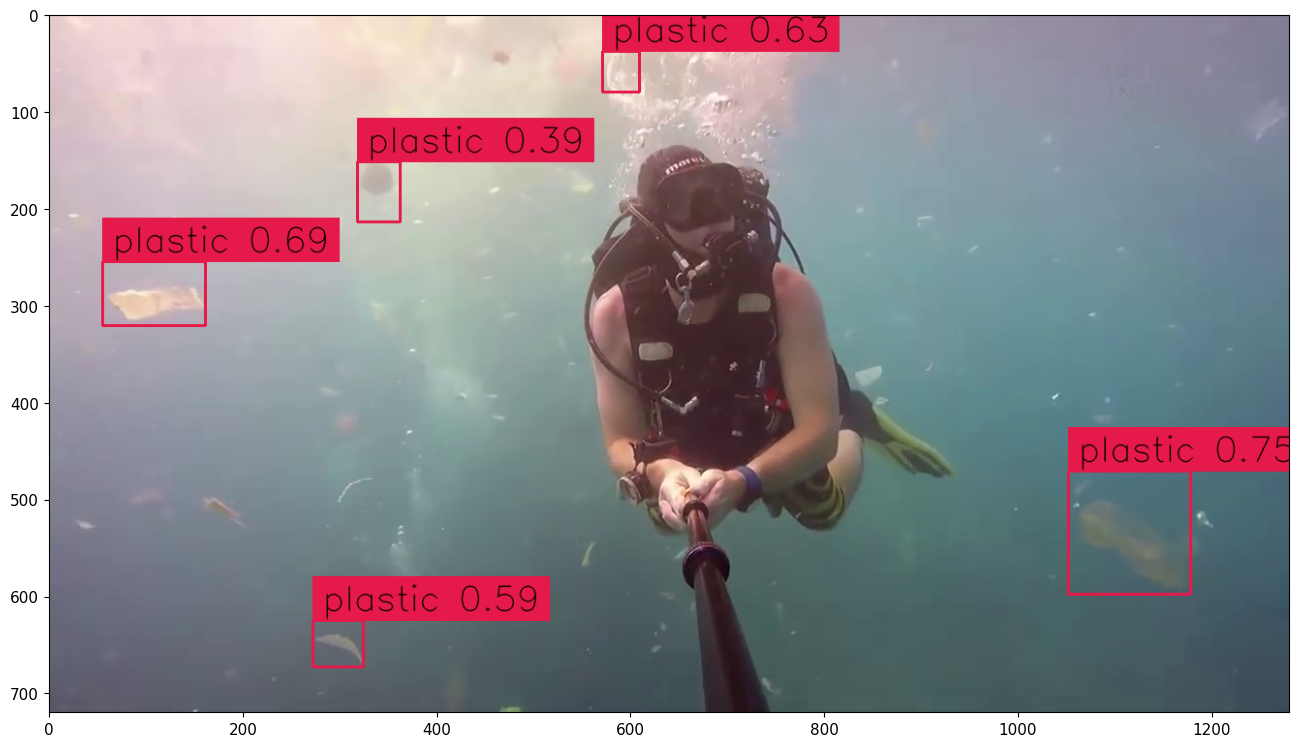


0: 384x640 7 plastics, 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


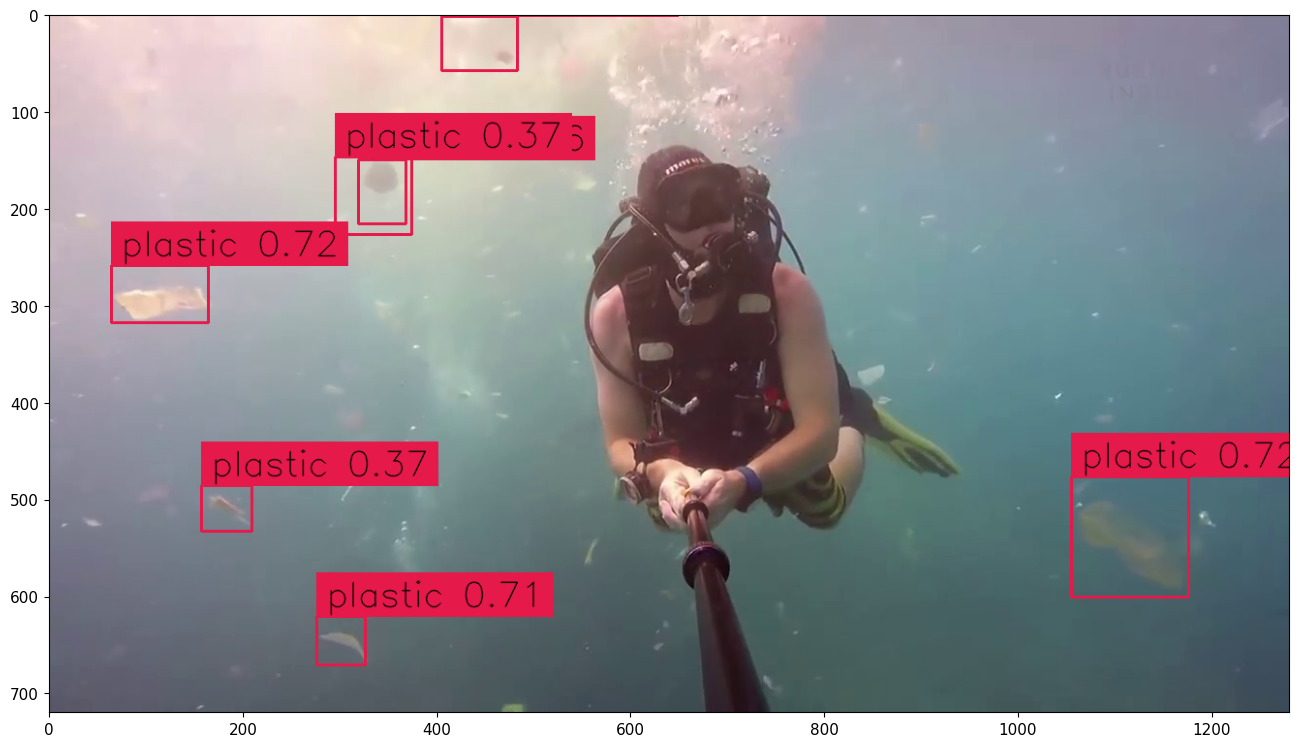

In [26]:
import cv2

# Define the start time in seconds (e.g., 51 seconds)
start_time_seconds = 51

# Open the video file
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Set the start frame based on the desired start time
start_frame = int(start_time_seconds * cap.get(cv2.CAP_PROP_FPS))
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=0, text_scale=1.2,)

# Process and display frames from the start_time_seconds
for i in range(10):  # Display the first 10 frames from the specified time
    ret, frame = cap.read()  # Read the next frame

    if not ret:
        break  # Break the loop if there are no more frames

    # model prediction on single frame and conversion to supervision Detections
    results = model(frame)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    # format custom labels
    labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, tracker_id
        in detections
    ]

    # annotate and display frame
    frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

    %matplotlib inline
    show_frame_in_notebook(frame, (16, 16))

# Release the video capture object
cap.release()


In [27]:
# # create frame generator
# generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# # create instance of BoxAnnotator
# box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=0, text_scale=1.2,)
# # box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2, font=cv2.FONT_HERSHEY_SIMPLEX, font_color=(0, 0, 255))
# # acquire first video frame
# iterator = iter(generator)
# frame = next(iterator)
# # model prediction on single frame and conversion to supervision Detections
# results = model(frame)
# detections = Detections(
#     xyxy=results[0].boxes.xyxy.cpu().numpy(),
#     confidence=results[0].boxes.conf.cpu().numpy(),
#     class_id=results[0].boxes.cls.cpu().numpy().astype(int)
# )
# # format custom labels
# labels = [
#     f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
#     for _, confidence, class_id, tracker_id
#     in detections
# ]
# # annotate and display frame
# frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

# %matplotlib inline
# show_frame_in_notebook(frame, (16, 16))

In [19]:
# def save_frame(frame, figsize, SOURCE_VIDEO_PATH):
#     fig, ax = plt.subplots(figsize=figsize)
#     ax.imshow(frame)
#     ax.axis('off')
#     fig.savefig(save_path, dpi=1500)  # Set the desired DPI value
#     plt.close(fig)
    
# save_path = '/home/nadiera/Downloads/image.png'  # Provide the desired save path
# save_frame(frame, (16, 16), save_path)

In [28]:
# settings
# LINE_START = Point(50, 1500)
# LINE_END = Point(3840-50, 1500)
LINE_START = Point(0, 750)
LINE_END = Point(750, 0)

TARGET_VIDEO_PATH = f"/home/nadiera/Downloads//home/nadiera/Downloads/A Diver Filmed Shocking Footage Of Plastic Waste Off The Coast Of Bali Results.mp4"

In [29]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=23, total_frames=4788)

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.4)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=0.4)

# # open target video file
# with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
#     # loop over video frames
#     for frame in tqdm(generator, total=video_info.total_frames):
#         # model prediction on single frame and conversion to supervision Detections
#         results = model(frame)
#         detections = Detections(
#             xyxy=results[0].boxes.xyxy.cpu().numpy(),
#             confidence=results[0].boxes.conf.cpu().numpy(),
#             class_id=results[0].boxes.cls.cpu().numpy().astype(int)
#         )
#         # filtering out detections with unwanted classes
#         mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
#         detections.filter(mask=mask, inplace=True)
#         # tracking detections
#         tracks = byte_tracker.update(
#             output_results=detections2boxes(detections=detections),
#             img_info=frame.shape,
#             img_size=frame.shape
#         )
#         tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
#         detections.tracker_id = np.array(tracker_id)
#         # filtering out detections without trackers
#         mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
#         detections.filter(mask=mask, inplace=True)
#         # format custom labels
#         labels = [
#             f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
#             for _, confidence, class_id, tracker_id
#             in detections
#         ]
#         # updating line counter
#         line_counter.update(detections=detections)
#         # annotate and display frame
#         frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
#         line_annotator.annotate(frame=frame, line_counter=line_counter)
#         sink.write_frame(frame)

with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames with tqdm
    for frame in tqdm(generator, total=video_info.total_frames, desc="Processing Frames"):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

Processing Frames:   0%|          | 0/4788 [00:00<?, ?it/s]


0: 384x640 2 plastics, 9.1ms
Speed: 18.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 plastics, 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plastic, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plastic, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plastic, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 0.9ms postprocess per image a

In [ ]:
# Path to the resultant video file
resultant_video_path = TARGET_VIDEO_PATH

# Open the video file for viewing
cap = cv2.VideoCapture(resultant_video_path)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error: Couldn't open the video file.")
else:
    # Get the frames per second (fps) of the video
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    while True:
        # Read a frame from the video
        ret, frame = cap.read()

        if not ret:
            break  # Break the loop if there are no more frames

        # Display the frame
        cv2.imshow('Resultant Video', frame)

        # Break the loop if the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()